In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime

dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

In [2]:
# read ptsd records
fp = dir.joinpath('EHR', 'ptsd_record.csv.gz')
ptsd_record = pd.read_csv(fp, compression="gzip")
patients_ptsd = ptsd_record['pat_enc_csn_sid'].unique()

# read flow table of patient EHR records
fp = dir.joinpath('EHR', 'flowsheet.csv.gz')
data = pd.read_csv(fp, compression="gzip")
data = data.drop(columns = ['meas_comment', 'meas_template_id'])
# Note: pandas took 50 seconds to load the table. Consider porting to PySpark RDD

In [3]:
fp = dir.joinpath('EHR', 'd_flo_measures.csv.gz')
dict = pd.read_csv(fp, compression="gzip")

names = ["State Behavioral Scale",
"-3 Unresponsive", 
"-2 Responsive to noxious stimuli", 
"-1 Responsive to gentle touch or voice",
"0 Awake and Able to calm",
"+1 Restless and difficult to calm",
"+2 Agitated",
"State Behavioral Scale (SBS)",
"Achieved Level of Sedation",
"Sedation / Delirium",
"Richmond Agitation - Sedation Scale",
"Richmond agitation sedation scale",
"Richmond Agitation Sedation Scale (RASS)"]

# dict[dict['disp_name'].isin(names)]


In [4]:
# flow_meas_id for SBS and RASS
fmid = [304080016, 304080017, 304080018, 304080019, 304080020, 304080021]

sbs = data[data['meas_id'].isin(fmid)]
print(sbs.shape)
# 25878 entries

# calculate sbs score from offset
sbs['SBS'] = sbs['meas_id'] - 304080019
sbs = sbs.drop(columns=['meas_value', 'meas_id'])
sbs['recorded_time'] = pd.to_datetime(sbs['recorded_time'], format='%Y-%m-%d %H:%M:%S')
sbs_indiv = sbs.groupby('pat_enc_csn_sid')

# Identify patients with SBS and waveform data
patients_ehr = list(sbs_indiv.groups.keys())

patients = set(patients_ehr) & set(patients_ptsd)
print(len(patients))

(25878, 5)
581


C:\Users\swu82\AppData\Local\Temp\ipykernel_1676\2226515026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbs['SBS'] = sbs['meas_id'] - 304080019


In [5]:
fp = dir.joinpath('EHR', 'vent_dur.csv.gz')
vent_record = pd.read_csv(fp, compression="gzip")

mech_vent = [5, 6, 7]
vent_record = vent_record[vent_record['level'].isin(mech_vent)]

patient_on_vent = set(vent_record['pat_enc_csn_sid'])
len(patient_on_vent)

1872

In [6]:
fp = dir.joinpath('EHR', 'med_admin.csv.gz')
med_admin = pd.read_csv(fp, compression="gzip")

excl_drugs = ['NEUROMUSCULAR BLOCKING AGENTS', 'BETA-ADRENERGIC AGENTS', 'ALPHA/BETA-ADRENERGIC BLOCKING AGENTS', 'BETA-ADRENERGIC BLOCKING AGENTS']

med_admin_filter = med_admin[med_admin['pharm_classname'].isin(excl_drugs)]
# med_admin_filter['pharm_classname'].unique()
patients_med = set(med_admin_filter['pat_enc_csn_sid'])

len(patients_med)

C:\Users\swu82\AppData\Local\Temp\ipykernel_1676\2220072747.py:2: DtypeWarning: Columns (26,40) have mixed types. Specify dtype option on import or set low_memory=False.
  med_admin = pd.read_csv(fp, compression="gzip")


1200

In [7]:
patient_on_vent = patient_on_vent & patients
patient_on_med = patients_med & patients
len(patient_on_vent), len(patient_on_med)

(257, 166)

In [8]:
patient_no_med = patients - patient_on_med
patient_on_vent = patient_on_vent & patient_no_med

In [9]:
patient_on_vent_sbs = sbs[sbs['pat_enc_csn_sid'].apply(lambda x: x in patient_on_vent)]['SBS']
patient_sbs = sbs[sbs['pat_enc_csn_sid'].apply(lambda x: x in patient_no_med)]['SBS']

(array([ 52.,   0., 160.,   0., 344.,   0., 896.,   0., 211., 239.]),
 array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <BarContainer object of 10 artists>)

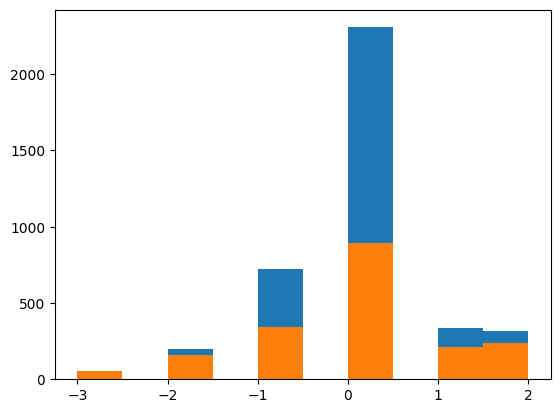

In [10]:
plt.hist(patient_sbs, label='on vent')
plt.hist(patient_on_vent_sbs, label='no vent')

# Inclusion Exclusion criteria round 1
- patients on ventilator
        - contains MEDIBUSVITALS file (from Drager ventilator)
        - overlapping ventilator time in (vent_dur)
        - 
- patient on beta blocker
- patients on neuromuscular blockers

### Mechanical ventilators

levels of ventilator support
- 1: room air
- 2: supplemental O2
- 3: regular nasal cannula
- 4: high-flow nasal cannula
- 5: noninvasive positive pressure ventilation
- 6: conventional mechanical ventilation
- 7: high freq oscillation or jet ventilation 

In [11]:
def remove_vent(patients, verbose = True):
    fp = dir.joinpath('EHR', 'vent_dur.csv.gz')
    vent_record = pd.read_csv(fp, compression="gzip")

    mech_vent = [5, 6, 7]
    vent_record = vent_record[vent_record['level'].isin(mech_vent)]

    patient_on_vent = set(vent_record['pat_enc_csn_sid']) & patients
    filtered_patients = patients - patient_on_vent
    # filtered_patients = patient_on_vent
    if verbose:
        print(f'{len(filtered_patients)} removed for mechanical ventilation \n{len(patients)} patients in original list, {len(filtered_patients)} after filtering')

    return filtered_patients

In [12]:
p_no_vent = remove_vent(patients)

324 removed for mechanical ventilation 
581 patients in original list, 324 after filtering


### Drug
exclude neuromuscular and beta blockers

- medication dictionary: d_med
- accm_med_admin
- anes_dur

In [7]:
# fp = dir.joinpath('EHR', 'med_admin.csv.gz')
# med_admin = pd.read_csv(fp, compression="gzip")
# print(med_admin.keys())
# print(med_admin['pharm_classname'].unique())

In [13]:
def remove_drugs(patients, verbose = True):
    fp = dir.joinpath('EHR', 'med_admin.csv.gz')
    med_admin = pd.read_csv(fp, compression="gzip")

    excl_drugs = ['NEUROMUSCULAR BLOCKING AGENTS', 'BETA-ADRENERGIC AGENTS', 'ALPHA/BETA-ADRENERGIC BLOCKING AGENTS', 'BETA-ADRENERGIC BLOCKING AGENTS']

    med_admin_filter = med_admin[med_admin['pharm_classname'].isin(excl_drugs)]
    # med_admin_filter['pharm_classname'].unique()
    patients_med = set(med_admin_filter['pat_enc_csn_sid'])

    filtered_patients = patients - patients_med
    if verbose:
        print(f'{len(patients_med)} removed for drugs \n{len(patients)} patients in original list, {len(filtered_patients)} after filtering')

    return filtered_patients

In [14]:
p_no_drugs = remove_drugs(patients)

C:\Users\swu82\AppData\Local\Temp\ipykernel_1676\193545468.py:3: DtypeWarning: Columns (26,40) have mixed types. Specify dtype option on import or set low_memory=False.
  med_admin = pd.read_csv(fp, compression="gzip")


1200 removed for drugs 
581 patients in original list, 415 after filtering


In [15]:
p_no_drugs = np.array(list(p_no_drugs))
p_no_vent = np.array(list(p_no_vent))
print(len(p_no_drugs), len(p_no_vent))
np.save('./DONOTPUSH/patients', p_no_drugs)
np.save('./DONOTPUSH/patients_novent', p_no_vent)

415 324


# Inclusion Exclusion 2

Committee meeting feedback: 
- Preserve ventilator patients since SBS designed for ventilated patients and this population most likely to have low SBS scores
- Instead remove respiration rate from data since low discrimination power
- Usually patients desaturate before crashing